# 1. 타겟 변수 분석

In [1]:
%run library_list.py
%matplotlib inline  
%precision 3

train data set은 11 개의 feature를 가진 1015 개의 데이터 샘플로 이루어져 있습니다.
test data set은 10 개의 feature를 가진 436 개의 데이터 샘플로 이루어져 있습니다.


'%.3f'

가장 먼저 진행할 것은 통계량을 살펴보는 것입니다.

In [2]:
target = train.target
target.describe()

count    1.01500000e+03
mean     8.24320445e+06
std      1.23956736e+07
min      4.00000000e+05
25%      2.53500000e+06
50%      4.21500000e+06
75%      8.92750000e+06
max      1.50015008e+08
Name: target, dtype: float64

## 1.1 위치 추정

데이터가 주어졌을 때, 데이터를 살펴보는 가장 기초적인 단계는 **대푯값**을 구하는 것입니다. 이는 대부분의 값이 어디쯤에 위치하는지를 나타내는 값입니다. 먼저 대표적인 평균값과 중간값을 구해보도록 하겠습니다.

In [3]:
# 평균과 중간값 
print("평균값 : {}".format(target.mean()))
print("중간값 : {}".format(target.median()))
print('중간값과 평균값의 차이 : ', target.median() - target.mean())



평균값 : 8243204.450246305
중간값 : 4215000.0
중간값과 평균값의 차이 :  -4028204.450246305


데이터의 평균값과 중간값의 차이가 굉장히 심한 편이며 이는 평균값이 중간값보다 크다는 것을 의미합니다. 

따라서 두 값의 차이가 크다는 것은, 데이터에 이상치가 많을 수 있음을 의미합니다. 

이 상황에서는 평균값을 데이터의 대푯값으로 사용하기에 적절하지 않습니다. 이를 한 번 그려서 확인해보겠습니다.

가격이 비싼 중고차들이 많다는 것을 아래의 그래프를 통해서 확인할 수 있음 이것이 평균값을 데이터의 대푯값으로 활용하는데 어려움을 줌

> 이 경우, 평균을 조금 변형한 **절사평균** 개념을 이용할 수 있습니다. 절사 평균은 데이터들을 크기 순으로 나열한 후, 양끝에서 일정 비율만큼의 데이터를 삭제한 뒤 남은 값들로 평균을 구합니다. 

아래의 코드는 각각 데이터의 양 끝에서 10%, 15%, 20%, 25% 제거하여 절사평균을 구하는 코드입니다.

절사평균을 구하기 위해서 scipy.stats의 trim_mean 함수를 이용합니다.

trim_mean 함수는 trim_mean(데이터, 절사할 비율) 형태로 이용하면 됩니다.

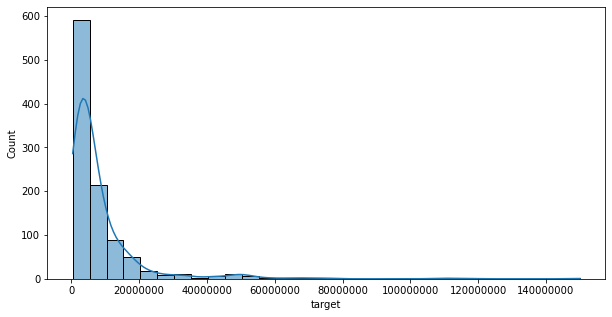

In [4]:
fig,ax = plt.subplots(1,1,figsize=[10,5])
sns.histplot(target,bins = 30,kde = True,ax=ax)
plt.ticklabel_format(style="plain")
# xlabel 
plt.show()

In [5]:
from scipy.stats import trim_mean 

for trim in [0.0,0.1,0.15,0.2,0.25]:
    print(f"{trim*100}% 절사평균 : ",trim_mean(target, trim))
print("중간값 : {:.3f}".format(target.median()))

0.0% 절사평균 :  8243204.450246305
10.0% 절사평균 :  5653857.329643296
15.0% 절사평균 :  5252582.29113924
20.0% 절사평균 :  4967098.536945812
25.0% 절사평균 :  4764495.106090373
중간값 : 4215000.000


데이터를 5%씩 제거해갈수록 절사평균이 중간값에 가까워지는 것을 확인할 수 있습니다. 

특히, 0% 절사평균 (=평균)과 10% 절사평균 차이가 굉장히 큰 것으로 보아, 데이터 분포의 양 옆 10%에 이상치가 위치할 가능성이 높습니다.

## 1.2 변이추정

데이터의 특징을 요약하는 요소는 위치 외에도 변이가 있습니다. 변이는 데이터 값이 얼마나 밀집해 있는지, 혹은 퍼져 있는지를 나타내는 **산포도**를 나타냅니다. 

변이추정의 기본은 **편차**를 기본으로 합니다. 우리에게 익숙한 분산 또는 표준편차가 주로 이용됩니다. 

In [6]:
print("분산 : ",target.var())
print("표준편차 : ",target.std())

분산 :  153652724096224.0
표준편차 :  12395673.603972638


표준편차가 굉장히 큽니다. 

앞서 평균값이 데이터의 대푯값으로 적절하지 않을 수 있따는 점을 상기해볼 때, 표준편차 또한 데이터의 변이를 나타내기에 적절하지 않을 수 있습니다. 이 때, 사용할 수 있는 값이 중간값의 **중위절대편차**(MAD)입니다. 중위절대편차는 중위값과의 편차에 대한 중위값입니다. 

중위값과 마찬가지로 이상치에 대해 덜 민감합니다.

아래의 코드는 데이터의 중위절대편차를 구하는 코드입니다. 중위절대편차를 계산하기 위해 statsmodels.api의 robust.scale.mad 함수를 이용합니다.

In [7]:
import statsmodels.api as sm 

print("중위절대편차 : ",sm.robust.scale.mad(target))

중위절대편차 :  3409985.1025628843


In [8]:
# 구간 (m-mad, m+mad)을 구해 중위값 근방의 주요 데이터들이 속한 구간을 구해보자.
target.median() - sm.robust.scale.mad(target), target.median() + sm.robust.scale.mad(target)

(805014.8974371157, 7624985.102562884)

어쩌면 이 구간 내의 가격에 속한 데이터들이 그나마 적정 가격선인 데이터이고, 이 구간 외에 있는 데이터들은 지나치게 가격이 비싼 데이터일 가능성이 있습니다.

추후에 입력변수들에 대한 전처리와 분석이 마친 뒤, 이들 구간 밖에 있는 데이터들을 살펴볼 필요가 있겠습니다.

주의! 분산, 표준편차, 중위절대편차는 모두 데이터가 정규분포에서 왔다고 가정합니다. 우리의 데이터가 정규분포를 따르지 않는다면 이 추정치들에 대한 해석은 적절하지 않을 수 있습니다

## 1.3 사분위수범위(IQR)

편차를 기준으로한 산포도는 데이터가 얼마나 모였는지를 나타내지만, 데이터가 얼마나 퍼져있는지를 살펴보고 변이를 추정할 수도 있습니다. 

이때, 가장 기본이 되는 측도는 최댓값과 최솟값의 차이인 범위입니다. 그러나 최댓값이나 최솟값, 혹은 이들 근방에 있는 양 끝 값들은 이상치일 가능성이 높기 때문에, 이들을 지우고서 범위를 알아볼 수 있습니다. 

이때, 주로 사용하는 것이 **사분위수 범위**입니다. 이는 데이터를 크기별로 나열했을 때, 하위 25%와 상위 25% 데이터를 제거해 구한 범위입니다.

pandas의 DataFrame은 사분위수를 구할 수 있는 quantile 메서드를 제공합니다

In [9]:
# 최대, 최소, 범위 
print("최댓값 : ",target.max())
print("최솟값 : ",target.min())
print("범위 : ",target.max()-target.min())

최댓값 :  150015008
최솟값 :  400000
범위 :  149615008


In [10]:
# 사분위수 범위 
print('상위 25% : ', target.quantile(0.75))
print('하위 25% : ', target.quantile(0.25))
print('사분위수 범위 : ',target.quantile(0.75) - target.quantile(0.25))

상위 25% :  8927500.0
하위 25% :  2535000.0
사분위수 범위 :  6392500.0


범위와 사분위수 범위 사이의 차이가 큽니다. 조금 더 자세히 살펴보면, 최댓값과 상위 25%값 사이의 차이가 굉장히 큽니다. 그리고 최솟값과 하위 25%값 사이의 차이는 상대적으로 작습니다. 

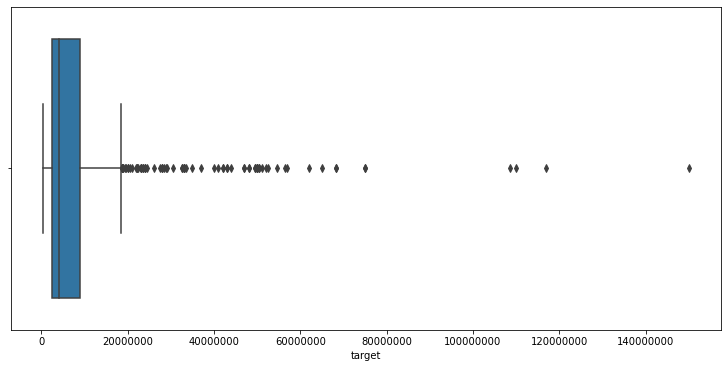

In [11]:
fig,ax = plt.subplots(1,1,figsize=[10,5], constrained_layout = True)
sns.boxplot(x= target)
plt.ticklabel_format(style="plain",axis="x")
plt.show()

그래프를 보시면 수집된 타겟 데이터는 정규분포를 따르고 있지 않습니다.

## 1.4 왜도와 첨도

앞선 분석에서 우리 데이터가 정규분포에서 벗어나있다는 것을 확인할 수 있었습니다. 

왜도와 척도는 데이터의 분포가 정규분포에서 얼마나 벗어난 모양인지를 측정해주는 지표들입니다. 

각각의 개념을 대략적으로 살펴보고 그 값을 Python으로 구해 분석해보겠습니다.

__왜도(Skewness)__

왜도는 정규분포와 비교해서 확률변수의 분포가 얼마나 치우쳐 있는지의 정도를 나타냅니다. 

- 왜도가 0인 경우 확률변수가 정규분포를 에 가깝습니다.
- 왜도가 양수인 경우 확률분포가 오른쪽으로 치우칩니다.
- 왜도가 음수인 경우 확률분포가 왼쪽으로 치우칩니다.


<img src = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Negative_and_positive_skew_diagrams_%28English%29.svg/700px-Negative_and_positive_skew_diagrams_%28English%29.svg.png">

그림 : Negative Skew (왼), Positive Skew(오)

In [12]:
print('왜도 : ',target.skew())

왜도 :  4.9552768084421


해석

- 가격이 저렴한 매물은 많지만, 가격이 비싼 매물은 희소하다. 

__첨도(Kurtosis)__

첨도는 확률분포의 꼬리가 얼마나 두꺼운지를 나타냅니다. 

- 첨도가 3인 경우 확률변수가 정규분포에 가깝습니다.
- 첨도가 3보다 큰 경우 확률분포가 정규분포보다 꼬리가 두껍습니다.
- 첨도가 3보다 작은인 경우 확률분포가 정규분포보다 꼬리가 얇습니다.

<img src = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Standard_symmetric_pdfs.svg/440px-Standard_symmetric_pdfs.svg.png">

꼬리가 굵어질수록 첨도가 크다는 것을 의미함 

In [13]:
# Dataframe의 kurt() 메서드를 사용하면 왜도를 알 수 있다.
print('첨도 : ', target.kurt())

첨도 :  35.55992197898911


첨도의 값이 35에 가깝습니다. 이는 데이터가 정규분포에 비해 꼬리가 매우 두꺼움을 의미합니다. 

일반적으로 첨도가 크면 __데이터에 이상치가 많은 것으로 생각합니다.__

정리해보겠습니다. 

- 왜도가 굉장히 크다. 데이터가 정규분포로부터 굉장히 벗어나 있다. 따라서 정규분포를 가정하는 많은 통계기법들은 소용이 없을 수 있다. 예를들어, 이 데이터는 평균값을 데이터의 대푯값으로 사용하기에 부적합하다.
- 첨도가 굉장히 크다. 데이터에 이상치가 많을 수 있다. 이 경우 이상치 탐치 알고리즘을 적용해 데이터 전처리를 시도해볼 수 있다.

## 1.5 분석 자동화 

지금까지 위치분석, 변이분석, 사분위수범위, 왜도와 첨도 등을 통해 타겟변수를 분석해보았습니다.

타겟변수는 수치형변수이므로, 지금까지의 분석 방법은 타겟변수 뿐만 아니라 입력변수에 속한 수치형변수들을 분석하는 데에 사용할 수 있을 것입니다.

따라서 위 모든 분석과정을 하나의 함수로 작성해 다음부터는 수치형변수 데이터를 입력하기만 하면 각각의 분석값을 출력해주도록 하면 편리할 것입니다.

여기에는 각자의 아이디어를 무궁무진하게 응용할 수 있을 것입니다.

In [14]:
numerical_analysis(target)

{'평균': 8243204.450,
 '중위값': 4215000.000,
 '10.0% 절사평균': 5653857.329643296,
 '15.0% 절사평균': 5252582.29113924,
 '20.0% 절사평균': 4967098.536945812,
 '25.0% 절사평균': 4764495.106090373,
 '분산': 153652724096224.000,
 '표준편차': 12395673.604,
 '중위절대편차': 3409985.1025628843,
 '-1sigma': -4152469.154,
 '+1sigma': 20638878.054,
 '-1MAD': 805014.8974371157,
 '+1MAD': 7624985.102562884,
 '최댓값': 150015008,
 '최솟값': 400000,
 '범위': 149615008,
 '삼분위수': 8927500.0,
 '일분위수': 2535000.0,
 '사분위수범위': 6392500.0,
 '왜도': 4.9552768084421,
 '첨도': 35.55992197898911}